In [1]:
pip install torch_geometric

  Obtaining dependency information for torch_geometric from https://files.pythonhosted.org/packages/65/4e/6f9a75548a93fedcd4514ae2de9bee1e91bade6b73252b4da32f0e42ac52/torch_geometric-2.4.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch_geometric 
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.utils import to_dense_batch

from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('/kaggle/input/inn-competition/Trainset-Evaluation/Train_Set.csv')
ts = pd.read_csv('/kaggle/input/inn-competition/Transaction/InnoTech_Trans.csv')
# For prototype phase we remove the nan values
ts=ts.dropna()
ts = ts.reset_index().drop(columns='index')

# TEMP LINE CODE
df = df.drop_duplicates(subset=['CARD'])

ts = ts.drop(columns=['Terminal_ID'])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
le = LabelEncoder()  
le.fit(np.unique(np.concatenate([ts['Primary_ID'].values,ts['Second_ID'].values,df['CARD'].values])).tolist())

ts['Primary_ID'] = le.transform(ts['Primary_ID'])
ts['Second_ID'] = le.transform(ts['Second_ID'])
df['CARD'] = le.transform(df['CARD'])

# ts = pd.get_dummies(ts, columns=['Date'], prefix='Date')

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(sparse=False, drop='first')  # 'first' to drop one of the columns to avoid multicollinearity

column_transformer = ColumnTransformer(
    transformers=[('onehot', encoder, ['Date'])],
    remainder='passthrough'  # keep the other columns as they are
)

df_encoded = pd.DataFrame(column_transformer.fit_transform(ts))


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
ts=pd.concat([ts,df_encoded],axis=1).drop(columns=['Date'])

In [8]:
import torch
from torch_geometric.data import Data

def construct_graph(card_id,y):
    """
    This function will create a graph of transaction for each card base on the transaction dataset. The created graph
    is directed which means each CARD_ID can be source or destination of the transaction.

    params:
        card_id 
        ts: transaction dataset

    return:

        graph 
    """

    card_to_index = ts[ts['Primary_ID']==card_id].index
    card_in_index = ts[ts['Second_ID']==card_id].index
    
    edge_index_from = []
    edge_index_to = []
    # TODO : which feature is good for base node
    node_features = [np.random.normal(0, 1, 104)]
    
    for i,index in zip(card_to_index,range(1,len(card_to_index)+1)):
        node_features.append(ts.loc[i].values)
        edge_index_from.append(0)
        edge_index_to.append(index)

    for i,index in zip(card_in_index,range(len(card_to_index)+1, 
                                           len(card_to_index)+len(card_in_index)+2+1)):
        node_features.append(ts.loc[i].values)
        edge_index_from.append(index)
        edge_index_to.append(0)

    data = Data(x=torch.tensor(node_features), edge_index=torch.tensor([edge_index_from,edge_index_to]),y=y)

    return data


In [9]:
from tqdm import tqdm
from multiprocessing import Pool

def process_data(args):
    i, y = args
    return construct_graph(i, y)

data = []

# Number of processes to use (adjust as needed)
num_processes = 4

# Create a pool of processes
with Pool(num_processes) as pool:
    # Use tqdm with imap_unordered to show progress
    for result in tqdm(pool.imap_unordered(process_data, zip(df['CARD'], df['LABEL']), chunksize=1), total=len(df)):
        data.append(result)


  0%|          | 0/3235 [00:00<?, ?it/s]/tmp/ipykernel_42/2398828424.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  data = Data(x=torch.tensor(node_features), edge_index=torch.tensor([edge_index_from,edge_index_to]),y=y)
/tmp/ipykernel_42/2398828424.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  data = Data(x=torch.tensor(node_features), edge_index=torch.tensor([edge_index_from,edge_index_to]),y=y)
  0%|          | 2/3235 [00:00<03:34, 15.04it/s]/tmp/ipykernel_42/2398828424.py:37: UserWarning: Creating a tensor fro

In [10]:
# Save the prepared data
torch.save(data,'/kaggle/working/graph_data.pt')

In [201]:
# import os
# import torch
# from torch_geometric.data import Dataset, Data
# from torch_geometric.utils import to_dense_batch

# class CustomGraphDataset(Dataset):
#     def __init__(self, root, transform=None):
#         self.root = root
#         self.transform = transform
#         self.graph_files =root
#         self.data = torch.load(self.graph_files)
#         self.max_num_nodes = self.find_max_num_nodes()
#         self.max_num_edge_index = self.find_max_num_edge_index()
        
#     def find_max_num_edge_index(self):
#         max_num_edge_index = max(data.edge_index.shape[1] for data in self.data)
#         return max_num_edge_index
    
#     def find_max_num_nodes(self):
#         max_num_nodes = max(data.num_nodes for data in self.data)
#         return max_num_nodes
    
#     def indices(self):
#         return list(range(self.len()))

#     def len(self):
#         return len(self.data)

#     def get(self, idx):
        
#         num_nodes_to_pad = self.max_num_nodes - self.data[idx].num_nodes
#         num_edge_to_pad = self.max_num_edge_index - self.data[idx].edge_index.shape[1]
        
#         # Pad num_nodes with zeros
#         self.data[idx].x = torch.cat([self.data[idx].x, torch.zeros(num_nodes_to_pad)])
        
#         # Pad edge_index with zeros
#         self.data[idx].edge_index = torch.cat([self.data[idx].edge_index, torch.zeros(2,num_edge_to_pad)],dim=1)
#         self.data[idx].edge_attr = torch.cat([self.data[idx].edge_attr,torch.zeros(num_edge_to_pad,104)])
#         # Update the number of nodes in the data object
#         self.data[idx].num_nodes = self.max_num_nodes

#         return self.data[idx]

In [202]:
# import torch
# from torch_geometric.data import Data
# from torch_geometric.utils import to_dense_batch

# def collate_fn(batch):
#     batch = to_dense_batch(batch)
#     return Data(x=batch.x, edge_index=batch.edge_index, y=batch.y)

In [203]:
# root = '/kaggle/working/graph_data.pt'
# train_dataset = CustomGraphDataset(root)
# train_dataset.max_num_nodes

24651

In [9]:
from torch_geometric.loader import DataLoader

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# # test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # for step, data in enumerate(train_loader):
# #     print(f'Step {step + 1}:')
# #     print('=======')
# #     print(f'Number of graphs in the current batch: {data.num_graphs}')
# #     print(data)
# #     print()

In [37]:
data = torch.load('/kaggle/working/graph_data.pt')

In [38]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Assuming 'data' is your list of PyTorch Geometric datasets

# Split the list of data into training and testing subsets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create DataLoader for training
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Create DataLoader for testing
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [18]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)


In [16]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BatchNorm1d  # Corrected import

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(104, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x



model = GCN(64)

model.apply(weights_init)
print(model)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
#          print(data.x.shape)
#          print(data.edge_index.shape)
#          print(data.edge_attr.shape)
#          print(data.x.shape)
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.long())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader: # Iterate in batches over the training/test dataset.
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


GCN(
  (conv1): GCNConv(104, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(64, 64)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [17]:
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')


Epoch: 001, Train Acc: 0.6343
Epoch: 002, Train Acc: 0.5153
Epoch: 003, Train Acc: 0.2974
Epoch: 004, Train Acc: 0.6352
Epoch: 005, Train Acc: 0.4192
Epoch: 006, Train Acc: 0.5666
Epoch: 007, Train Acc: 0.6921
Epoch: 008, Train Acc: 0.4485
Epoch: 009, Train Acc: 0.6705
Epoch: 010, Train Acc: 0.6788
Epoch: 011, Train Acc: 0.6454
Epoch: 012, Train Acc: 0.6556
Epoch: 013, Train Acc: 0.6665
Epoch: 014, Train Acc: 0.6798
Epoch: 015, Train Acc: 0.6247
Epoch: 016, Train Acc: 0.6594
Epoch: 017, Train Acc: 0.6782
Epoch: 018, Train Acc: 0.6779
Epoch: 019, Train Acc: 0.6192
Epoch: 020, Train Acc: 0.6798
Epoch: 021, Train Acc: 0.6538
Epoch: 022, Train Acc: 0.6764
Epoch: 023, Train Acc: 0.4578
Epoch: 024, Train Acc: 0.7221
Epoch: 025, Train Acc: 0.7221
Epoch: 026, Train Acc: 0.6655
Epoch: 027, Train Acc: 0.5372
Epoch: 028, Train Acc: 0.7592
Epoch: 029, Train Acc: 0.7017
Epoch: 030, Train Acc: 0.7178
Epoch: 031, Train Acc: 0.6807
Epoch: 032, Train Acc: 0.6896
Epoch: 033, Train Acc: 0.6396
Epoch: 034

In [80]:
22137*104

2302248

In [19]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BatchNorm1d  # Corrected import

import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import global_mean_pool, GATConv

class GATSkip(torch.nn.Module):
    def __init__(self, hidden_channels, heads=1):
        super(GATSkip, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(104, hidden_channels, heads=heads)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=heads)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=heads)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings with skip connections
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)

        # Skip connections
        x = x1 + x2 + x3

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x



model = GCN(256)

model.apply(weights_init)
print(model)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
#          print(data.x.shape)
#          print(data.edge_index.shape)
#          print(data.edge_attr.shape)
#          print(data.x.shape)
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.long())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader: # Iterate in batches over the training/test dataset.
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


GCN(
  (conv1): GCNConv(104, 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(256, 256)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(256, 256)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=256, out_features=3, bias=True)
)


In [20]:
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
#     test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')


Epoch: 001, Train Acc: 0.5471
Epoch: 002, Train Acc: 0.5839
Epoch: 003, Train Acc: 0.2856
Epoch: 004, Train Acc: 0.2983
Epoch: 005, Train Acc: 0.5376
Epoch: 006, Train Acc: 0.4862
Epoch: 007, Train Acc: 0.6269
Epoch: 008, Train Acc: 0.6986
Epoch: 009, Train Acc: 0.6646
Epoch: 010, Train Acc: 0.6862
Epoch: 011, Train Acc: 0.6958
Epoch: 012, Train Acc: 0.4662
Epoch: 013, Train Acc: 0.6575
Epoch: 014, Train Acc: 0.6612
Epoch: 015, Train Acc: 0.6386
Epoch: 016, Train Acc: 0.7076
Epoch: 017, Train Acc: 0.6479
Epoch: 018, Train Acc: 0.7113
Epoch: 019, Train Acc: 0.6563
Epoch: 020, Train Acc: 0.6921
Epoch: 021, Train Acc: 0.5051
Epoch: 022, Train Acc: 0.7008
Epoch: 023, Train Acc: 0.7131
Epoch: 024, Train Acc: 0.6971
Epoch: 025, Train Acc: 0.7147
Epoch: 026, Train Acc: 0.5750
Epoch: 027, Train Acc: 0.6989
Epoch: 028, Train Acc: 0.6903
Epoch: 029, Train Acc: 0.7199
Epoch: 030, Train Acc: 0.6383
Epoch: 031, Train Acc: 0.6825
Epoch: 032, Train Acc: 0.7264
Epoch: 033, Train Acc: 0.7422
Epoch: 034

In [21]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BatchNorm1d  # Corrected import

import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import global_mean_pool, GATConv

class GATSkip(torch.nn.Module):
    def __init__(self, hidden_channels, heads=1):
        super(GATSkip, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(104, hidden_channels, heads=heads)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=heads)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=heads)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings with skip connections
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.elu(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)

        # Skip connections
        x = x1 + x2 + x3

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x



model = GCN(256)

model.apply(weights_init)
print(model)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
#          print(data.x.shape)
#          print(data.edge_index.shape)
#          print(data.edge_attr.shape)
#          print(data.x.shape)
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.long())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader: # Iterate in batches over the training/test dataset.
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


GCN(
  (conv1): GCNConv(104, 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(256, 256)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(256, 256)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=256, out_features=3, bias=True)
)


In [22]:
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
#     test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')


Epoch: 001, Train Acc: 0.5481
Epoch: 002, Train Acc: 0.5861
Epoch: 003, Train Acc: 0.3184
Epoch: 004, Train Acc: 0.3054
Epoch: 005, Train Acc: 0.3376
Epoch: 006, Train Acc: 0.4436
Epoch: 007, Train Acc: 0.6272
Epoch: 008, Train Acc: 0.6859
Epoch: 009, Train Acc: 0.6717
Epoch: 010, Train Acc: 0.6847
Epoch: 011, Train Acc: 0.7042
Epoch: 012, Train Acc: 0.4612
Epoch: 013, Train Acc: 0.6804
Epoch: 014, Train Acc: 0.6628
Epoch: 015, Train Acc: 0.6767
Epoch: 016, Train Acc: 0.6968
Epoch: 017, Train Acc: 0.6770
Epoch: 018, Train Acc: 0.7023
Epoch: 019, Train Acc: 0.6541
Epoch: 020, Train Acc: 0.6764
Epoch: 021, Train Acc: 0.6844
Epoch: 022, Train Acc: 0.6859
Epoch: 023, Train Acc: 0.7029
Epoch: 024, Train Acc: 0.6909
Epoch: 025, Train Acc: 0.7042
Epoch: 026, Train Acc: 0.6124
Epoch: 027, Train Acc: 0.7261
Epoch: 028, Train Acc: 0.6887
Epoch: 029, Train Acc: 0.7091
Epoch: 030, Train Acc: 0.6328
Epoch: 031, Train Acc: 0.6791
Epoch: 032, Train Acc: 0.7199
Epoch: 033, Train Acc: 0.7107
Epoch: 034

In [20]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BatchNorm1d  # Corrected import

import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import global_mean_pool, GATConv

class GATSkip(torch.nn.Module):
    def __init__(self, hidden_channels, heads=1):
        super(GATSkip, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(104, hidden_channels, heads=heads)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=heads)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=heads)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings with skip connections
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)

        # Skip connections
        x = x1 + x2 + x3

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x



model = GATSkip(256)

model.apply(weights_init)
print(model)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
#          print(data.x.shape)
#          print(data.edge_index.shape)
#          print(data.edge_attr.shape)
#          print(data.x.shape)
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.long())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader: # Iterate in batches over the training/test dataset.
         data.cuda()
         out = model(data.x.float(), data.edge_index.int(), data.batch)  # Perform a single forward pass.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


GATSkip(
  (conv1): GATConv(104, 256, heads=1)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(256, 256, heads=1)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(256, 256, heads=1)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=256, out_features=3, bias=True)
)


Epoch: 001, Train Loss: 1.1236, Train Acc: 0.5908, Test Acc: 0.6213
Epoch: 002, Train Loss: 0.8682, Train Acc: 0.6264, Test Acc: 0.6615
Epoch: 003, Train Loss: 0.8101, Train Acc: 0.6596, Test Acc: 0.6723
Epoch: 004, Train Loss: 0.9067, Train Acc: 0.6588, Test Acc: 0.6507
Epoch: 005, Train Loss: 0.7553, Train Acc: 0.7060, Test Acc: 0.7048
Epoch: 006, Train Loss: 0.8485, Train Acc: 0.6379, Test Acc: 0.6692
Epoch: 007, Train Loss: 0.8435, Train Acc: 0.6534, Test Acc: 0.6229
Epoch: 008, Train Loss: 0.8871, Train Acc: 0.6233, Test Acc: 0.5904
Epoch: 009, Train Loss: 0.7779, Train Acc: 0.6878, Test Acc: 0.6893
Epoch: 010, Train Loss: 0.7449, Train Acc: 0.6804, Test Acc: 0.6940
Epoch: 011, Train Loss: 0.7201, Train Acc: 0.7318, Test Acc: 0.7295
Epoch: 012, Train Loss: 0.7824, Train Acc: 0.7029, Test Acc: 0.7017
Epoch: 013, Train Loss: 1.0641, Train Acc: 0.4536, Test Acc: 0.4235
Epoch: 014, Train Loss: 0.7445, Train Acc: 0.6696, Test Acc: 0.6893
Epoch: 015, Train Loss: 0.7273, Train Acc: 0.730

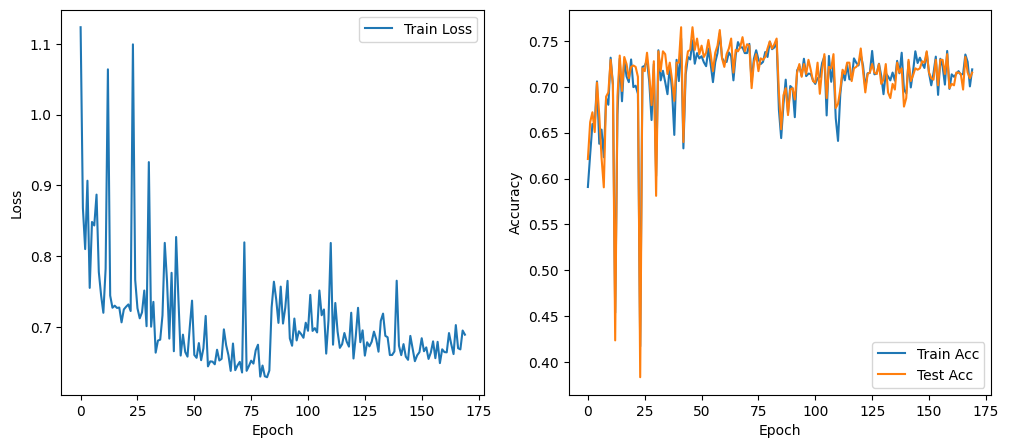

In [21]:
# Lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

def train_and_evaluate(epochs):
    for epoch in range(1, epochs + 1):
        train()
        train_loss = compute_loss(train_loader)
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def compute_loss(loader):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    for data in loader:
        data.cuda()
        out = model(data.x.float(), data.edge_index.int(), data.batch)
        loss = criterion(out, data.y.long())
        total_loss += loss.item()
        num_batches += 1
    return total_loss / num_batches

# Training and evaluation
train_and_evaluate(170)

In [72]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import TransformerConv, global_mean_pool
from torch.nn import BatchNorm1d  # Corrected import

import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import global_mean_pool, GATConv

class GATSkip(torch.nn.Module):
    def __init__(self, hidden_channels, heads=1):
        super(GATSkip, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = TransformerConv(104,hidden_channels, heads=heads)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = TransformerConv(hidden_channels,hidden_channels, heads=heads)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = TransformerConv(hidden_channels,hidden_channels, heads=heads)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin1 = Linear(hidden_channels,hidden_channels//2)
        self.bn4 = BatchNorm1d(hidden_channels//2)

        self.lin = Linear(hidden_channels//2, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings with skip connections
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)

        x2 = self.conv2(x1, edge_index) + x1 
        x2 = self.bn2(x2)
        x2 = F.relu(x2)

        x3 = self.conv3(x2, edge_index) + x2
        x3 = self.bn3(x3)

        # Skip connections
        x = x3

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.lin(x)

        return x



model = GATSkip(256)

model.apply(weights_init)
print(model)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
#          print(data.x.shape)
#          print(data.edge_index.shape)
#          print(data.edge_attr.shape)
#          print(data.x.shape)
         data.cuda()
         out = model(data.x.float(), data.edge_index.to(torch.int64), data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.long())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader: # Iterate in batches over the training/test dataset.
         data.cuda()
         out = model(data.x.float(), data.edge_index.to(torch.int64), data.batch)  # Perform a single forward pass.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Summary:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} parameters")

total_params = count_parameters(model)
print(f"\nTotal Parameters: {total_params}")


GATSkip(
  (conv1): TransformerConv(104, 256, heads=1)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): TransformerConv(256, 256, heads=1)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): TransformerConv(256, 256, heads=1)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=128, out_features=3, bias=True)
)
Model Summary:
conv1.lin_key.weight: 26624 parameters
conv1.lin_key.bias: 256 parameters
conv1.lin_query.weight: 26624 parameters
conv1.lin_query.bias: 256 parameters
conv1.lin_value.weight: 26624 parameters
conv1.lin_value.bias: 256 parameters
conv1.lin_skip.weight: 26624 parameters
conv1.lin_skip.bias: 256 parameters
bn1.weight: 256 parameters
bn1.bias: 256 parame

Epoch: 001, Train Loss: 0.6940, Train Acc: 0.6859, Test Acc: 0.7048
Epoch: 002, Train Loss: 0.6398, Train Acc: 0.7241, Test Acc: 0.7388
Epoch: 003, Train Loss: 0.6563, Train Acc: 0.7349, Test Acc: 0.7311
Epoch: 004, Train Loss: 0.6251, Train Acc: 0.7678, Test Acc: 0.7728
Epoch: 005, Train Loss: 0.6164, Train Acc: 0.7597, Test Acc: 0.7558
Epoch: 006, Train Loss: 0.5917, Train Acc: 0.7616, Test Acc: 0.7713
Epoch: 007, Train Loss: 0.6767, Train Acc: 0.7600, Test Acc: 0.7682
Epoch: 008, Train Loss: 0.5693, Train Acc: 0.7597, Test Acc: 0.7589
Epoch: 009, Train Loss: 0.6590, Train Acc: 0.7488, Test Acc: 0.7666
Epoch: 010, Train Loss: 0.5456, Train Acc: 0.7937, Test Acc: 0.7759
Epoch: 011, Train Loss: 0.6007, Train Acc: 0.7628, Test Acc: 0.7743
Epoch: 012, Train Loss: 0.5733, Train Acc: 0.7608, Test Acc: 0.7666
Epoch: 013, Train Loss: 0.5298, Train Acc: 0.7848, Test Acc: 0.7929
Epoch: 014, Train Loss: 0.5917, Train Acc: 0.7608, Test Acc: 0.7419
Epoch: 015, Train Loss: 0.5685, Train Acc: 0.779

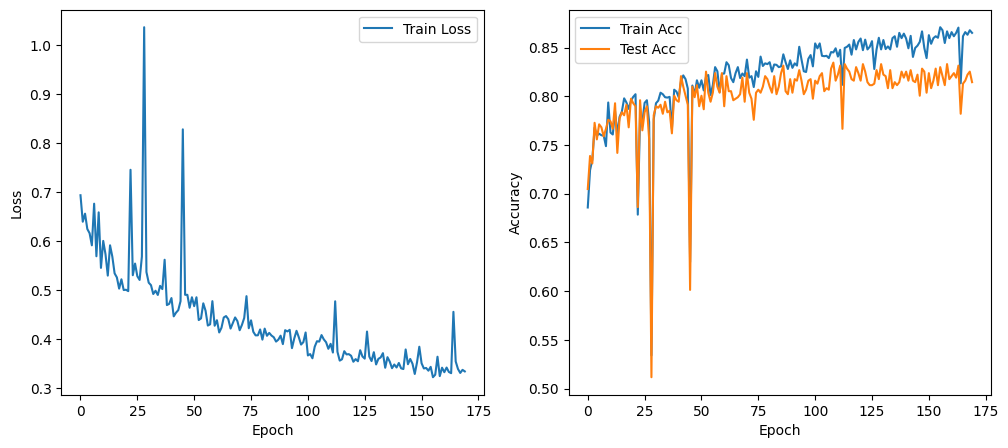

In [73]:
# Lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

def train_and_evaluate(epochs):
    for epoch in range(1, epochs + 1):
        train()
        train_loss = compute_loss(train_loader)
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def compute_loss(loader):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    for data in loader:
        data.cuda()
        out = model(data.x.float(), data.edge_index.to(torch.int64), data.batch)
        loss = criterion(out, data.y.long())
        total_loss += loss.item()
        num_batches += 1
    return total_loss / num_batches

# Training and evaluation
train_and_evaluate(170)

In [81]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import BatchNorm1d  # Corrected import

import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import global_mean_pool, GATConv

class GATSkip(torch.nn.Module):
    def __init__(self, hidden_channels, heads=1):
        super(GATSkip, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = EdgeConv()
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = TransformerConv(hidden_channels,hidden_channels, heads=heads)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = TransformerConv(hidden_channels,hidden_channels, heads=heads)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin1 = Linear(hidden_channels,hidden_channels//2)
        self.bn4 = BatchNorm1d(hidden_channels//2)

        self.lin = Linear(hidden_channels//2, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings with skip connections
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)

        x2 = self.conv2(x1, edge_index) + x1 
        x2 = self.bn2(x2)
        x2 = F.relu(x2)

        x3 = self.conv3(x2, edge_index) + x2
        x3 = self.bn3(x3)

        # Skip connections
        x = x3

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.lin(x)

        return x



model = GATSkip(256)

model.apply(weights_init)
print(model)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
#          print(data.x.shape)
#          print(data.edge_index.shape)
#          print(data.edge_attr.shape)
#          print(data.x.shape)
         data.cuda()
         out = model(data.x.float(), data.edge_index.to(torch.int64), data.batch)  # Perform a single forward pass.
         loss = -(criterion(out, data.y.long()))  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader: # Iterate in batches over the training/test dataset.
         data.cuda()
         out = model(data.x.float(), data.edge_index.to(torch.int64), data.batch)  # Perform a single forward pass.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.long()).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Summary:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} parameters")

total_params = count_parameters(model)
print(f"\nTotal Parameters: {total_params}")


TypeError: EdgeConv.__init__() missing 1 required positional argument: 'nn'

In [80]:
# Lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

def train_and_evaluate(epochs):
    for epoch in range(1, epochs + 1):
        train()
        train_loss = compute_loss(train_loader)
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def compute_loss(loader):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    for data in loader:
        data.cuda()
        out = model(data.x.float(), data.edge_index.to(torch.int64), data.batch)
        loss = -(criterion(out, data.y.long()))
        total_loss += loss.item()
        num_batches += 1
    return total_loss / num_batches

# Training and evaluation
train_and_evaluate(170)

Epoch: 001, Train Loss: -1355.3380, Train Acc: 0.2821, Test Acc: 0.2705


KeyboardInterrupt: 

In [26]:
from torch_geometric.datasets import DBLP


In [30]:
# path = osp.join(osp.dirname(osp.realpath()), '/kaggle/working/')
# We initialize conference node features with a single one-vector as feature:
dataset = DBLP('/kaggle/working/', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

Extracting /kaggle/working/raw/DBLP_processed.zip
Processing...


HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


Done!


In [43]:
a = dataset[0]

In [44]:
a.metadata()

(['author', 'paper', 'term', 'conference'],
 [('author', 'to', 'paper'),
  ('paper', 'to', 'author'),
  ('paper', 'to', 'term'),
  ('paper', 'to', 'conference'),
  ('term', 'to', 'paper'),
  ('conference', 'to', 'paper')])